In [12]:
import os
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Set the display option to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data_folder = '/content/drive/MyDrive/Dataset/data'
step_data_frames = []

# Loop through the data folder and its subfolders
for root, dirs, files in os.walk(data_folder):
    for filename in files:
        # Check if the file is a .csv file
        if filename.endswith('.csv'):
            csv_path = os.path.join(root, filename)
            step_mixed_path = os.path.join(root, filename.replace("Clipped","") + '.stepMixed')
#             print(csv_path,step_mixed_path)
            # Check if the corresponding .csv.stepMixed file exists
            if os.path.exists(step_mixed_path):


                # Read the .csv file
                step_data = pd.read_csv(csv_path, usecols =[1,2,3,4,5,6])
                step_data = step_data.dropna() # Removes Missing values

                # Reads StepIndices value - Start and End index of a step
                col_names = ['start_index','end_index']
                step_indices = pd.read_csv(step_mixed_path, names = col_names)

                #Removing Missing values and outliers
                step_indices = step_indices.dropna()
                step_indices = step_indices.loc[(step_indices.end_index < step_data.shape[0])]

#                 steps = []

#                 for start_index, end_index in step_indexes:
#                     step = step_data[start_index:end_index + 1]
#                     steps.append(step)


                # Create a labels column and initialize with default value
                step_data["Label"] = "No Label"

                # Assign "start" and "end" labels to corresponding rows
                for index, row in step_indices.iterrows():
                    step_data.loc[row['start_index'], "Label"] = "start"
                    step_data.loc[row['end_index'], "Label"] = "end"

                # Print the head of the DataFrame
#                 print(df.head())

                # Append the DataFrame to the list
                step_data_frames.append(step_data)

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(step_data_frames, ignore_index=True)
print(combined_df.shape)
test_path = os.path.join(data_folder,"testdata.csv")
test_df = pd.read_csv(test_path)

(722582, 7)


In [13]:
class StepDetectionDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.features = self.data.iloc[:, :6].values  # Extract the features
        self.labels = self.data.iloc[:, 6].values  # Extract the labels

        self.label_mapping = {'No Label': 0, 'start': 1, 'end': 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = torch.tensor(self.features[index], dtype=torch.float32)
        label = torch.tensor(self.label_mapping[self.labels[index]])

        return features, label

class StepDetectionTestDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.features = self.data.iloc[:, :6].values  # Extract the features

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = torch.tensor(self.features[index], dtype=torch.float32)
        return features

# Create the train, validation, test dataset

dataset = StepDetectionDataset(combined_df)
test_dataset = StepDetectionTestDataset(test_df)
print(test_df.shape)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

#Data Loading
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)
# for inputs, label in train_loader:
#     print(inputs)

(102091, 6)


In [14]:
# Define the Transformer model
class StepDetectionTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout):
        super(StepDetectionTransformer, self).__init__()

        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Fully connected layer for classification
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,3)

    def forward(self, x):
        x = x.unsqueeze(0)


        x = self.encoder(x)
        x = x.mean(dim=0) # Global average pooling over the sequence length
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model and other hyperparameters
input_dim = 6  # Number of input features (accelerometer + gyroscope readings)
hidden_dim = 64  # Dimension of the hidden states in the Transformer
num_layers = 2  # Number of Transformer layers
num_heads = 3  # Number of attention heads
dropout = 0.0  # Dropout rate

In [15]:
model = StepDetectionTransformer(input_dim, hidden_dim, num_layers, num_heads, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
#         print("Train",outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        correct += (torch.argmax(outputs, dim=1) == labels).int().sum().item()
        running_loss += loss.item()
    return running_loss / len(dataloader), correct / len(dataloader.dataset)

def validate(model, dataloader, criterion, device):
    model.eval()
    predictions = []
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())
#             print("Validate",outputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (torch.argmax(outputs, dim=1) == labels).int().sum().item()
    return running_loss / len(dataloader), correct / len(dataloader.dataset)
    return predictions

# def test(model, dataloader, device):
#     model.eval()
#     predictions = []

#     with torch.no_grad():
#         for inputs, _ in dataloader:
#             inputs = inputs.to(device)
#             outputs = model(inputs)
#             probabilities = torch.softmax(outputs, dim=1).tolist()
#             predictions.extend(probabilities)

#     return predictions

num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer,device)
    val_loss, val_acc = validate(model, val_loader, criterion,device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    print(f'Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}')
    print('----------------------------------')

Epoch 1/10
Train Loss: 0.1732, Train Accuracy: 0.9645
Test Loss: 0.1674, Test Accuracy: 0.9639
----------------------------------
Epoch 2/10
Train Loss: 0.1607, Train Accuracy: 0.9645
Test Loss: 0.1582, Test Accuracy: 0.9639
----------------------------------
Epoch 3/10
Train Loss: 0.1585, Train Accuracy: 0.9645
Test Loss: 0.1590, Test Accuracy: 0.9639
----------------------------------
Epoch 4/10
Train Loss: 0.1580, Train Accuracy: 0.9645
Test Loss: 0.1646, Test Accuracy: 0.9639
----------------------------------
Epoch 5/10
Train Loss: 0.1576, Train Accuracy: 0.9645
Test Loss: 0.1557, Test Accuracy: 0.9639
----------------------------------
Epoch 6/10
Train Loss: 0.1571, Train Accuracy: 0.9645
Test Loss: 0.1557, Test Accuracy: 0.9639
----------------------------------
Epoch 7/10
Train Loss: 0.1566, Train Accuracy: 0.9645
Test Loss: 0.1572, Test Accuracy: 0.9639
----------------------------------
Epoch 8/10
Train Loss: 0.1563, Train Accuracy: 0.9645
Test Loss: 0.1580, Test Accuracy: 0.

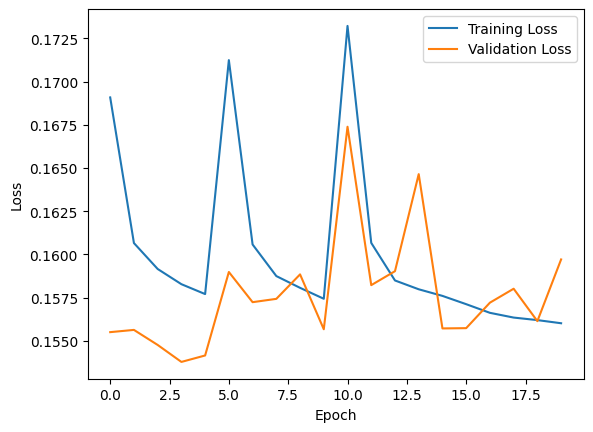

In [16]:
# Plotting the training loss vs. validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
#Output.csv Generation
def test(model, dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
#
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            predictions.extend(probabilities)

    return predictions

def write_output_file(file_path, predictions):
    with open(file_path, 'w') as file:
        file.write('index,start,end\n')
        for time_point, pred in enumerate(predictions):
            start_prob = pred[1]  # Probability of being the start of a step
            end_prob = pred[2]  # Probability of being the end of a step

            line = f'{time_point},{start_prob:.6f},{end_prob:.6f}\n'
            file.write(line)

output_file = '/content/sample_data/step_predictions_CNN128_.csv'
test_predictions = test(model, test_loader,device)
write_output_file(output_file,test_predictions)